In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('CapstoneProjectData.csv')
df1 = df.copy()
df1 = df1.set_index('date')
df1.head()

,chg_ted,chg_usd,chg_ffr,chg_cpi,target
date,,,,,
2/1/1986,-0.13,-1.2149,-0.28,0.4,1
3/1/1986,0.05,-4.4735,-0.38,-0.2,1
4/1/1986,-0.12,-2.4337,-0.49,-0.6,0
5/1/1986,-0.04,-1.0595,-0.14,-0.4,1
6/1/1986,0.02,-2.6492,0.07,0.3,1


In [3]:
train = df1.loc[:'12/1/2009']
cv = df1.loc['1/1/2010':'12/1/2013']
test = df1.loc['1/1/2014':]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']])
train.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']] = scaler.transform(train.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']])
cv.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']] = scaler.transform(cv.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']])
test.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']] = scaler.transform(test.loc[:,['chg_ted','chg_usd','chg_ffr','chg_cpi']])

C:\Users\Jack\Anaconda2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
train.head()

,chg_ted,chg_usd,chg_ffr,chg_cpi,target
date,,,,,
2/1/1986,0.430769,0.348515,0.371585,0.648426,1
3/1/1986,0.500000,0.009822,0.316940,0.556710,1
4/1/1986,0.434615,0.221835,0.256831,0.495567,0
5/1/1986,0.465385,0.364667,0.448087,0.526139,1
6/1/1986,0.488462,0.199437,0.562842,0.633140,1


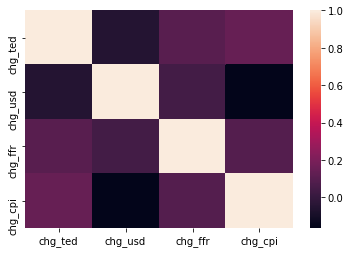

In [6]:
sb.heatmap(train[['chg_ted','chg_usd','chg_ffr','chg_cpi']].corr())

In [7]:
train[['chg_ted','chg_usd','chg_ffr','chg_cpi']].corr()

,chg_ted,chg_usd,chg_ffr,chg_cpi
chg_ted,1.000000,-0.051625,0.100365,0.143114
chg_usd,-0.051625,1.000000,0.043917,-0.164027
chg_ffr,0.100365,0.043917,1.000000,0.095044
chg_cpi,0.143114,-0.164027,0.095044,1.000000


C:\Users\Jack\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015241860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000016E626D8>]], dtype=object)

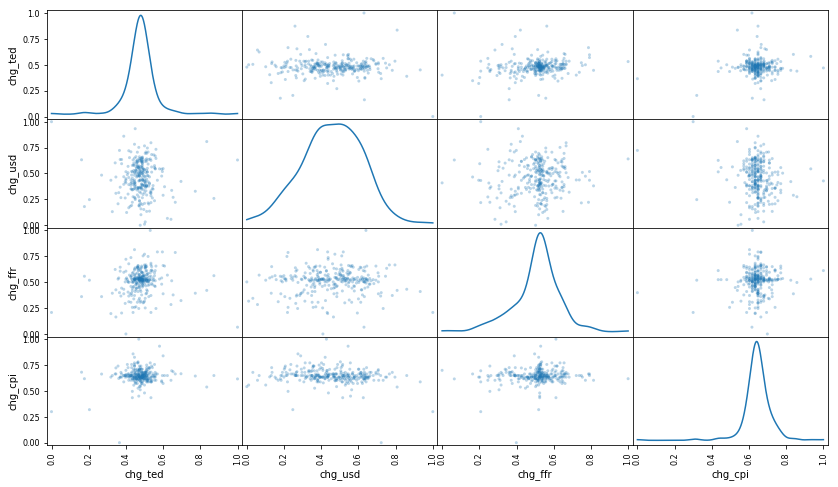

In [8]:
pd.scatter_matrix(train[['chg_ted','chg_usd','chg_ffr','chg_cpi']], alpha = 0.3, figsize = (14,8), diagonal = 'kde')

**Prepare for testing**

In [9]:
X_train = train[['chg_ted','chg_usd','chg_ffr','chg_cpi']]
y_train = train['target']
X_cv = cv[['chg_ted','chg_usd','chg_ffr','chg_cpi']]
y_cv = cv['target']
X_test = test[['chg_ted','chg_usd','chg_ffr','chg_cpi']]
y_test = test['target']

**Create F-Score Metric**

In [10]:
tp = np.sum(y_train.values)
fp = y_train.shape[0] - tp
tn = 0
fn = 0

accuracy = tp / float(X_train.shape[0])
recall = tp / float(tp + fn)
precision = tp / float(tp + fp)

beta = 0.5
beta_sq = beta**2
fscore = (1+beta_sq)*((precision*recall)/((beta_sq*precision)+recall))

print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.5993, F-score: 0.6515]


In [11]:
from sklearn.metrics import fbeta_score, accuracy_score

In [12]:
def train_predict(learner, X_train, y_train, X_test, y_test, beta): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    learner = learner.fit(X_train, y_train)
        
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    results['acc_train'] = float(accuracy_score(y_train, predictions_train))
        
    results['acc_cv'] = float(accuracy_score(y_test, predictions_test))
    
    results['f_train'] = float(fbeta_score(y_train, predictions_train, beta))
        
    results['f_cv'] = float(fbeta_score(y_test, predictions_test, beta))
       
    # Success
    print "{} trained".format(learner.__class__.__name__)
        
    # Return the results
    return results

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

**Benchmark Model**

In [14]:
clf_A = LogisticRegression(random_state = 3)

results_bm = {}
clf_name = clf_A.__class__.__name__
results_bm[clf_name] = train_predict(clf_A, X_train, y_train, X_cv, y_cv, beta)

LogisticRegression trained


In [15]:
results_bm

{'LogisticRegression': {'acc_cv': 0.6458333333333334,
  'acc_train': 0.5993031358885017,
  'f_cv': 0.6950672645739912,
  'f_train': 0.6515151515151515}}

In [16]:
pd.DataFrame(results_bm)

,LogisticRegression
acc_cv,0.645833
acc_train,0.599303
f_cv,0.695067
f_train,0.651515


**Model Testing**

In [17]:
clf_B = KNeighborsClassifier()
clf_C = DecisionTreeClassifier(random_state = 3)
clf_D = SVC(random_state = 3)

results = {}
for clf in [clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_cv, y_cv, beta)

KNeighborsClassifier trained
DecisionTreeClassifier trained
SVC trained


In [18]:
results

{'DecisionTreeClassifier': {'acc_cv': 0.4791666666666667,
  'acc_train': 1.0,
  'f_cv': 0.5825242718446602,
  'f_train': 1.0},
 'KNeighborsClassifier': {'acc_cv': 0.3958333333333333,
  'acc_train': 0.7212543554006968,
  'f_cv': 0.5345911949685535,
  'f_train': 0.7510288065843622},
 'SVC': {'acc_cv': 0.6458333333333334,
  'acc_train': 0.5993031358885017,
  'f_cv': 0.6950672645739912,
  'f_train': 0.6515151515151515}}

In [19]:
pd.DataFrame(results)

,DecisionTreeClassifier,KNeighborsClassifier,SVC
acc_cv,0.479167,0.395833,0.645833
acc_train,1.000000,0.721254,0.599303
f_cv,0.582524,0.534591,0.695067
f_train,1.000000,0.751029,0.651515


In [20]:
for clf in [clf_A, clf_B, clf_C, clf_D]:
    print clf.__class__.__name__, '\n', clf.predict(X_cv), '\n'
print 'True Values', '\n', y_cv.values

LogisticRegression 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] 

KNeighborsClassifier 
[1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1
 0 0 0 1 1 0 1 1 0 1 0] 

DecisionTreeClassifier 
[0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 1 0 1 0 1 0 0 0] 

SVC 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] 

True Values 
[0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 0 1 1 1 1]


**PCA**

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca.explained_variance_ratio_ 

array([ 0.49825121,  0.27332703,  0.13129313,  0.09712864])

**Model Tuning**

In [23]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

clf = clf_B

parameters = {'n_neighbors': range(1,30)}

scorer = make_scorer(fbeta_score, beta=beta)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf_knn = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_cv)
best_predictions = best_clf_knn.predict(X_cv)

print "Unoptimized model\n------"
print "Accuracy score on cv data: {:.4f}".format(accuracy_score(y_cv, predictions))
print "F-score on cv data: {:.4f}".format(fbeta_score(y_cv, predictions, beta = beta))
print "\nOptimized Model\n------"
print "Final accuracy score on the cv data: {:.4f}".format(accuracy_score(y_cv, best_predictions))
print "Final F-score on the cv data: {:.4f}".format(fbeta_score(y_cv, best_predictions, beta = beta))

C:\Users\Jack\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Jack\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on cv data: 0.3958
F-score on cv data: 0.5346

Optimized Model
------
Final accuracy score on the cv data: 0.6042
Final F-score on the cv data: 0.6744


In [24]:
best_clf_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='uniform')

In [25]:
clf = clf_C

parameters = {'min_samples_split': range(2,50)}

scorer = make_scorer(fbeta_score, beta=beta)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf_tree = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_cv)
best_predictions = best_clf_tree.predict(X_cv)

print "Unoptimized model\n------"
print "Accuracy score on cv data: {:.4f}".format(accuracy_score(y_cv, predictions))
print "F-score on cv data: {:.4f}".format(fbeta_score(y_cv, predictions, beta = beta))
print "\nOptimized Model\n------"
print "Final accuracy score on the cv data: {:.4f}".format(accuracy_score(y_cv, best_predictions))
print "Final F-score on the cv data: {:.4f}".format(fbeta_score(y_cv, best_predictions, beta = beta))

Unoptimized model
------
Accuracy score on cv data: 0.4792
F-score on cv data: 0.5825

Optimized Model
------
Final accuracy score on the cv data: 0.5208
Final F-score on the cv data: 0.6303


In [26]:
best_clf_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=13,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [27]:
clf = clf_D

parameters = {'C' : [.01,.25,.05,.1,.5,1.,2.,4.,8.], 
                     'gamma' : ['auto',.01,.25,.05,.1,.5,1.,2.,4.,8.]}

scorer = make_scorer(fbeta_score, beta=beta)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf_svm = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_cv)
best_predictions = best_clf_svm.predict(X_cv)

print "Unoptimized model\n------"
print "Accuracy score on cv data: {:.4f}".format(accuracy_score(y_cv, predictions))
print "F-score on cv data: {:.4f}".format(fbeta_score(y_cv, predictions, beta = beta))
print "\nOptimized Model\n------"
print "Final accuracy score on the cv data: {:.4f}".format(accuracy_score(y_cv, best_predictions))
print "Final F-score on the cv data: {:.4f}".format(fbeta_score(y_cv, best_predictions, beta = beta))

Unoptimized model
------
Accuracy score on cv data: 0.6458
F-score on cv data: 0.6951

Optimized Model
------
Final accuracy score on the cv data: 0.6458
Final F-score on the cv data: 0.6951


In [28]:
best_clf_svm

SVC(C=8.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=4.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=3, shrinking=True,
  tol=0.001, verbose=False)

**Testing**

In [29]:
classifiers = [clf_A, best_clf_knn, best_clf_tree, best_clf_svm]
test_results = {}
for clf in classifiers:
    test_preds = clf.predict(X_test)
    print 'Classifier :', clf.__class__.__name__
    print 'Accuracy on the test set :', accuracy_score(y_test, test_preds)
    print 'F-score on the test set :', fbeta_score(y_test, test_preds, beta = beta), '\n'

Classifier : LogisticRegression
Accuracy on the test set : 0.645833333333
F-score on the test set : 0.695067264574 

Classifier : KNeighborsClassifier
Accuracy on the test set : 0.604166666667
F-score on the test set : 0.678391959799 

Classifier : DecisionTreeClassifier
Accuracy on the test set : 0.4375
F-score on the test set : 0.546218487395 

Classifier : SVC
Accuracy on the test set : 0.645833333333
F-score on the test set : 0.695067264574 



In [30]:
for clf in [clf_A, best_clf_knn, best_clf_tree, best_clf_svm]:
    print clf.__class__.__name__, '\n', clf.predict(X_test), '\n'
print 'True Values', '\n', y_test.values

LogisticRegression 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] 

KNeighborsClassifier 
[1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1] 

DecisionTreeClassifier 
[1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0
 1 1 1 1 0 0 1 1 1 0 0] 

SVC 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1] 

True Values 
[0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1]


In [31]:
df1.columns.values

array(['chg_ted', 'chg_usd', 'chg_ffr', 'chg_cpi', 'target'], dtype=object)

Text(0,0.5,u'Change in USD Strength')

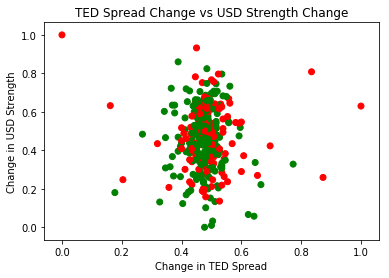

In [32]:
arr1 = df1['chg_ted']
arr2 = df1['chg_usd']
labl = df1['target']
color = ['red' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color = color)
plt.title('TED Spread Change vs USD Strength Change')
plt.xlabel('Change in TED Spread')
plt.ylabel('Change in USD Strength')

Text(0,0.5,u'Change in Fed Funds Rate')

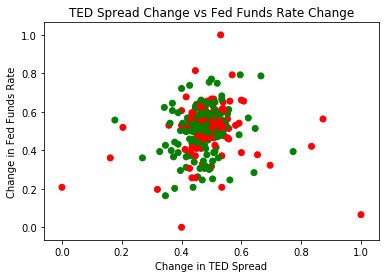

In [33]:
arr1 = df1['chg_ted']
arr2 = df1['chg_ffr']
labl = df1['target']
color = ['red' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color = color)
plt.title('TED Spread Change vs Fed Funds Rate Change')
plt.xlabel('Change in TED Spread')
plt.ylabel('Change in Fed Funds Rate')

Text(0,0.5,u'Change in Fed Funds Rate')

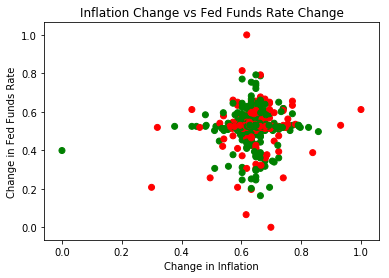

In [34]:
arr1 = df1['chg_cpi']
arr2 = df1['chg_ffr']
labl = df1['target']
color = ['red' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color = color)
plt.title('Inflation Change vs Fed Funds Rate Change')
plt.xlabel('Change in Inflation')
plt.ylabel('Change in Fed Funds Rate')

Text(0,0.5,u'Change in USD Strength')

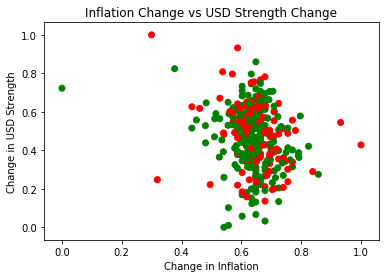

In [35]:
arr1 = df1['chg_cpi']
arr2 = df1['chg_usd']
labl = df1['target']
color = ['red' if l == 0 else 'green' for l in labl]
plt.scatter(arr1, arr2, color = color)
plt.title('Inflation Change vs USD Strength Change')
plt.xlabel('Change in Inflation')
plt.ylabel('Change in USD Strength')